# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Data Cleaning](#Data-Cleaning)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Features](#Features)
- [Linear Regression](#Linear-Regression-Model)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705396, 70)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,delta_run_exp,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,woba_value,woba_denom,xba,xwoba,babip_value,iso_value,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,count_re,bs_lin_weight,bs_lin_weight_scale,rv_above_avg,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,-0.073,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,2.0,0.0,1.0,0.174,0.158,0.0,0.0,61,4,9,0,5,0,5,0,0,0,0,2,1,0,1,1,0,0,0,0.098,-0.098,0.000,-0.098,-0.25,0.0,1.209,-0.302,0.0,0.223,-0.184,-0.282,-0.141,-0.170,-0.472,-0.170
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,-0.027,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,1,0,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.000,0.0,0.293,-0.058,-0.058,-0.006,-0.007,-0.007,-0.007
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,-0.020,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,1,0,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.000,0.0,0.355,-0.051,-0.051,0.001,0.001,0.001,0.001
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,0.016,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,0,1,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.000,0.0,0.314,0.034,0.034,-0.003,-0.004,-0.004,-0.004
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,-0.189,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,2.0,0.0,1.0,0.100,0.090,0.0,0.0,60,2,9,0,5,0,5,0,0,0,0,1,1,0,1,0,0,0,0,0.254,-0.156,0.098,-0.156,-0.25,0.0,1.209,-0.302,0.0,0.355,-0.051,-0.207,0.001,0.001,-0.301,0.001


Using this wOBA by count, we can calculate the value of points scored by count.

(count wOBA after pitching – count wOBA before pitching) / wOBAscale (≈1.15 in Statcast csv data)

First, when the count changes, the actual RAA is calculated as:

(wOBA of the count after the pitch – wOBA of the count before the pitch) / 1.15

If a batted ball occurs, then this is used to calculate RAA:

(xwOBAvalue – wOBA of the count before the pitch) / wOBAscale

# Cleaning / EDA

### Features

In [3]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'release_extension',
                 'plate_x', 'plate_z', 'rv']]

# 'stand'

In [4]:
ff = features.loc[features['pitch_type'] == 'FF']
fc = features.loc[features['pitch_type'] == 'FC']
fastball = ff.append(fc)
si = features.loc[features['pitch_type'] == 'SI']
fastball = fastball.append(si)
print('Fastball shape:', fastball.shape)
sl = features.loc[features['pitch_type'] == 'SL']
cu = features.loc[features['pitch_type'] == 'CU']
breaking_ball = sl.append(cu)
kc = features.loc[features['pitch_type'] == 'KC']
breaking_ball = breaking_ball.append(kc)
print('Breaking Ball:', breaking_ball.shape)
ch = features.loc[features['pitch_type'] == 'CH']
fs = features.loc[features['pitch_type'] == 'FS']
offspeed = ch.append(fs)
print('Off speed shape:', offspeed.shape)
rhp = features.loc[features['p_throws'] == 'R']
print('RHP shape:', rhp.shape)
lhp = features.loc[features['p_throws'] == 'L']
print('LHP shape:', lhp.shape)
#rhp_rhh = features.loc[(features['p_throws'] == 'R') & (features['stand'] == 'R')]
#print('RHP & RHH shape:', rhp_rhh.shape)
#rhp_lhh = features.loc[(features['p_throws'] == 'R') & (features['stand'] == 'L')]
#print('RHP & LHH shape:', rhp_lhh.shape)
#lhp_rhh = features.loc[(features['p_throws'] == 'L') & (features['stand'] == 'R')]
#print('LHP & RHH shape:', lhp_rhh.shape)
#lhp_lhh = features.loc[(features['p_throws'] == 'L') & (features['stand'] == 'L')]
#print('LHP & LHH shape:', lhp_lhh.shape)
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
print('RHP Fastball shape:', rhp_fastball.shape)
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
print('LHP Fastball shape:', lhp_fastball.shape)
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
print('RHP Breaking Ball shape:', rhp_breaking_ball.shape)
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
print('LHP Breaking Ball shape:', lhp_breaking_ball.shape)
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
print('RHP Offspeed shape:', rhp_offspeed.shape)
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
print('LHP Offspeed shape:', lhp_offspeed.shape)
ff_r = rhp.loc[rhp['pitch_type'] == 'FF']
ff_l = lhp.loc[lhp['pitch_type'] == 'FF']
fc_r = rhp.loc[rhp['pitch_type'] == 'FC']
fc_l = lhp.loc[lhp['pitch_type'] == 'FC']
si_r = rhp.loc[rhp['pitch_type'] == 'SI']
si_l = lhp.loc[lhp['pitch_type'] == 'SI']
sl_r = rhp.loc[rhp['pitch_type'] == 'SL']
sl_l = lhp.loc[lhp['pitch_type'] == 'SL']
cu_r = rhp.loc[rhp['pitch_type'] == 'CU']
cu_l = lhp.loc[lhp['pitch_type'] == 'CU']
ch_r = rhp.loc[rhp['pitch_type'] == 'CH']
ch_l = lhp.loc[lhp['pitch_type'] == 'CH']

Fastball shape: (406250, 13)
Breaking Ball: (207975, 13)
Off speed shape: (91171, 13)
RHP shape: (496493, 13)
LHP shape: (208903, 13)
RHP Fastball shape: (283224, 13)
LHP Fastball shape: (123026, 13)
RHP Breaking Ball shape: (152378, 13)
LHP Breaking Ball shape: (55597, 13)
RHP Offspeed shape: (60891, 13)
LHP Offspeed shape: (30280, 13)


In [5]:
data.groupby(['player_name', 'pitch_type'], as_index = False)['rv_above_avg', 'rv'].sum()

,player_name,pitch_type,rv_above_avg,rv
0,"Abad, Fernando",CH,-4.676,-1.052
1,"Abad, Fernando",FC,-0.730,0.780
2,"Abad, Fernando",FF,1.025,2.837
3,"Abad, Fernando",KC,-2.988,3.354
4,"Abad, Fernando",SI,-3.458,7.717
...,...,...,...,...
3464,"Álvarez, José",CH,-21.505,-0.968
3465,"Álvarez, José",FC,-1.746,-0.840
3466,"Álvarez, José",FF,-7.891,1.774
3467,"Álvarez, José",SI,-29.104,8.949


In [6]:
data.groupby(['events'], as_index = False)['re24', 'rv_above_avg'].mean()

,events,re24,rv_above_avg
0,double,0.765841,0.863998
1,field_error,0.427661,0.444663
2,field_out,-0.249793,-0.405923
3,hit_by_pitch,0.340325,0.335008
4,home_run,1.394975,1.632701
5,single,0.457643,0.486939
6,triple,1.052801,1.206801
7,walk,0.313550,0.338175


In [7]:
data.groupby(['events'], as_index = False)['re24', 'rv'].mean()

,events,re24,rv
0,double,0.765841,1.165998
1,field_error,0.427661,0.747663
2,field_out,-0.249793,-0.103923
3,hit_by_pitch,0.340325,0.637008
4,home_run,1.394975,1.934701
5,single,0.457643,0.788939
6,triple,1.052801,1.508801
7,walk,0.313550,0.640175


In [8]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'bs_lin_weight', 'rv_above_avg'].mean()

,pitch_count,woba,wraa_change,bs_lin_weight,rv_above_avg
0,0-0,0.314,-0.012715,-0.003,0.005234
1,0-1,0.262,-0.022642,-0.013,-0.007069
2,0-2,0.196,-0.080462,-0.123,-0.199886
3,1-0,0.355,-0.010147,0.001,0.012935
4,1-1,0.293,-0.020787,-0.006,0.008790
...,...,...,...,...,...
7,2-1,0.352,-0.016841,0.000,0.019488
8,2-2,0.273,-0.129371,-0.168,-0.250068
9,3-0,0.622,-0.064147,0.053,0.199480
10,3-1,0.470,0.001302,0.115,0.273310


In [9]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'bs_lin_weight', 'rv'].mean()

,pitch_count,woba,wraa_change,bs_lin_weight,rv
0,0-0,0.314,-0.012715,-0.003,0.038423
1,0-1,0.262,-0.022642,-0.013,0.045727
2,0-2,0.196,-0.080462,-0.123,-0.087995
3,1-0,0.355,-0.010147,0.001,0.059814
4,1-1,0.293,-0.020787,-0.006,0.068386
...,...,...,...,...,...
7,2-1,0.352,-0.016841,0.000,0.085070
8,2-2,0.273,-0.129371,-0.168,-0.114041
9,3-0,0.622,-0.064147,0.053,0.314586
10,3-1,0.470,0.001302,0.115,0.425531


# Preprocessing

### Multicolinearity - VIF
**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** final_lin_weight_above_avg

In [10]:
features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(10)

,feature,VIF
9,rv,1.012208
7,plate_x,1.110543
4,release_pos_x,1.454762
2,pfx_x,1.466135
3,pfx_z,3.114446
8,plate_z,7.451706
1,spin_rate,50.839720
5,release_pos_z,103.361778
6,release_extension,152.722320
0,velo,277.759432


Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

# Linear Regression Model

## 4-Seam RHP 

In [11]:
features_ff_r = ff_r.select_dtypes([np.number])
X = features_ff_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_ff_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_ff_r = sm.OLS(y_train, X_train).fit()
pred_ff_r = ols_ff_r.predict(X_test)

fitted_vals_ff_r = ols_ff_r.fittedvalues
residuals_ff_r = ols_ff_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 3))
print(ols_ff_r.summary())

RMSE: 0.304
MAE: 0.157
                            OLS Regression Results                            
Dep. Variable:                     rv   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     182.4
Date:                Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:40:11   Log-Likelihood:                -32946.
No. Observations:              132276   AIC:                         6.591e+04
Df Residuals:                  132266   BIC:                         6.601e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const          

In [12]:
X = features_ff_r.drop(columns = ['rv'])
y = features_ff_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LinearRegression()

lr.fit(X_train, y_train)
pred_ff_r = lr.predict(X_test)
pred = lr.predict(X)
score_ff_r = lr.score(X_test, y_test)

print('R2 Score:', round(score_ff_r, 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 3))
print('Max Error:', round(metrics.max_error(y_test, pred_ff_r), 3))

R2 Score: 0.012
RMSE: 0.304
MAE: 0.157
Max Error: 2.154


### RHP 4-Seam Actual & Predicted Run Values

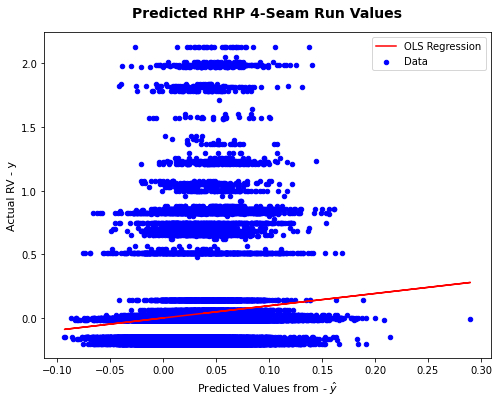

In [13]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_r, y_test, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_r, np.poly1d(np.polyfit(pred_ff_r, y_test, 1))(pred_ff_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP 4-Seam Probability Plot

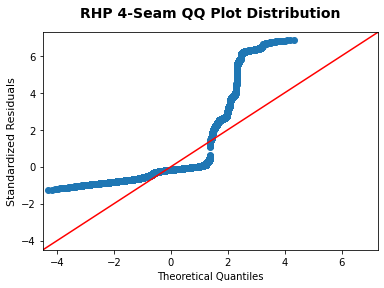

In [14]:
sm.qqplot(residuals_ff_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP 4-Seam RV Table

In [15]:
ff_r['n_pitches'] = [1 if x == 'FF' else 0 for x in ff_r['pitch_type']]
ff_r['xRV'] = pred
ff_r['xRV'] = round(ff_r['xRV'], 3)
grouped_ff_r = ff_r.groupby(['player_name', 'pitch_type'], as_index = False)['n_pitches', 'rv', 'xRV'].sum()

grouped_ff_r = pd.DataFrame(grouped_ff_r)
grouped_ff_r['RV/100'] = round(((grouped_ff_r['rv'] / grouped_ff_r['n_pitches']) * 100), 2)
grouped_ff_r['xRV/100'] = round(((grouped_ff_r['xRV'] / grouped_ff_r['n_pitches']) * 100), 2)

ff_r_group = pd.merge(ff_r, grouped_ff_r, how = 'left', on = ['player_name'])
ff_r_group.drop(columns = ['n_pitches_x', 'pitch_type_y'], inplace = True)
col_dict = {
    'pitch_type_x': 'pitch_type',
    'rv_x': 'rv_above_outs',
    'xRV_x': 'xrv_above_outs',
    'n_pitches_y': 'n_pitches',
    'rv_y': 'RV',
    'xRV_y': 'xRV'
}

ff_r_group.rename(columns = col_dict, inplace = True)
ff_r_rv_table = ff_r_group.groupby(['player_name', 'pitch_type'], as_index = False)['n_pitches', 'RV', 
                                                                                    'RV/100', 'xRV', 
                                                                                    'xRV/100'].mean()
ff_r_rv_table = pd.DataFrame(ff_r_rv_table)
print(ff_r_rv_table.shape)
ff_r_rv_table.head()

(593, 7)


,player_name,pitch_type,n_pitches,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",FF,207.0,17.376,8.39,6.130,2.96
1,"Abreu, Albert",FF,103.0,2.765,2.68,1.898,1.84
2,"Abreu, Bryan",FF,310.0,14.225,4.59,8.913,2.88
3,"Acevedo, Domingo",FF,88.0,6.004,6.82,4.439,5.04
4,"Adam, Jason",FF,125.0,7.373,5.90,3.240,2.59


rv_above_outs: run value from pitch to pitch

xrv_above_outs: expected run value from pitch to pitch

RV: sum of all run values

xRV: sum of all expected run values

RV/100: sum or RV divided by n_pitches times 100

xRV/100: sum or xRV divided by n_pitches times 100

### RHP 4-Seam RV by Velo & Spin Rate

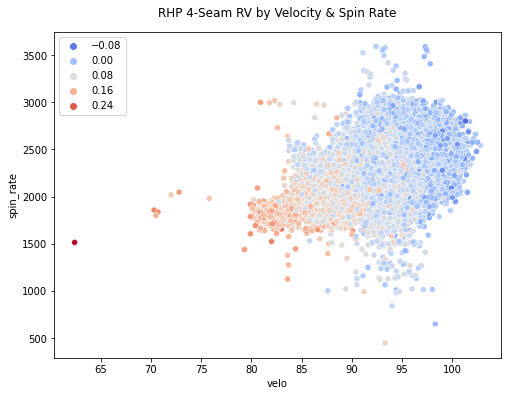

In [16]:
plt.figure(figsize = (8, 6))

#ff_r['xRV'] = pd.cut(ff_r['pred_rv'], [-0.2, 0, 10], labels = ['-0.2', '0.2'])
sns.scatterplot(data = ff_r_group, x = 'velo', y = 'spin_rate', hue = pred, palette = 'coolwarm')
plt.title('RHP 4-Seam RV by Velocity & Spin Rate', pad = 15);

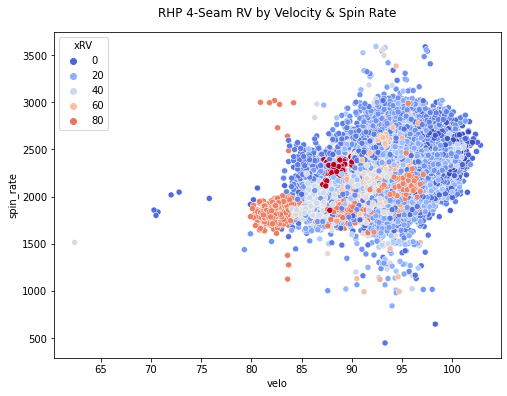

In [17]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_r_group, x = 'velo', y = 'spin_rate', hue = 'xRV', palette = 'coolwarm')
plt.title('RHP 4-Seam RV by Velocity & Spin Rate', pad = 15);

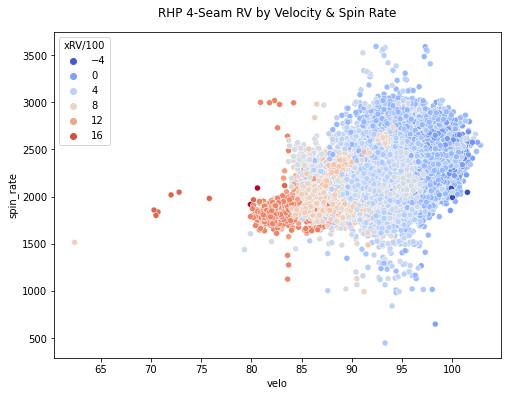

In [18]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_r_group, x = 'velo', y = 'spin_rate', hue = 'xRV/100', palette = 'coolwarm')
plt.title('RHP 4-Seam RV by Velocity & Spin Rate', pad = 15);

### RHP 4-Seam RV by Strike Zone

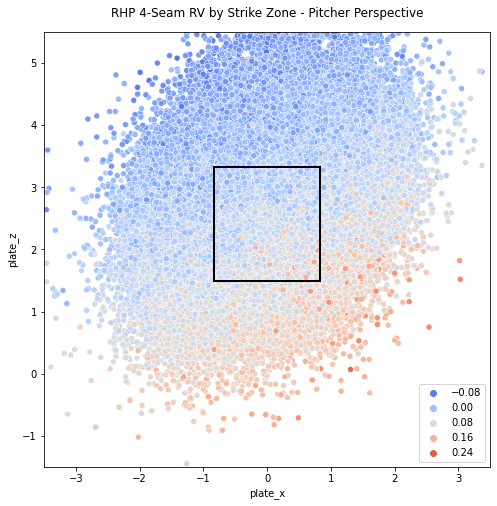

In [19]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_r, x = 'plate_x', y = 'plate_z', hue = pred, palette = 'coolwarm')
plt.xlim(-3.5, 3.5), plt.ylim(-1.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('RHP 4-Seam RV by Strike Zone - Pitcher Perspective', pad = 15);

### RHP 4-Seam RV by HB & VB

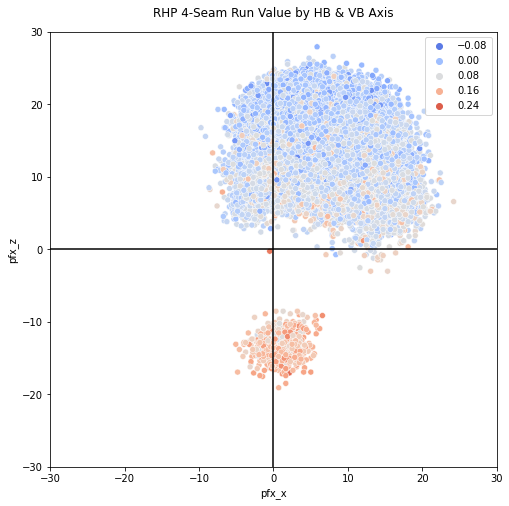

In [20]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_r, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
                # hue_norm = (-.1, 0.223))
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP 4-Seam Run Value by HB & VB Axis', pad = 15);

### RHP 4-Seam RV by Release Point

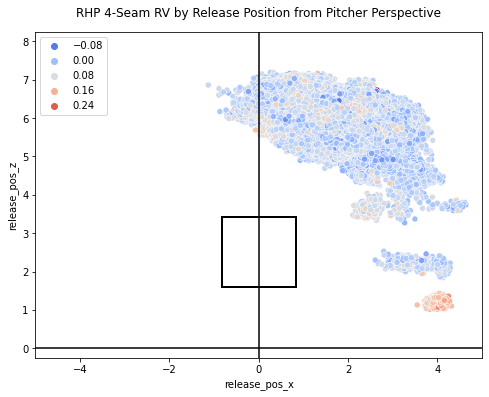

In [21]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_r, x = 'release_pos_x', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
# rect = mpatches.Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2)
# plt.gca().add_patch(rect)
plt.title('RHP 4-Seam RV by Release Position from Pitcher Perspective', pad = 15);

### RHP 4-Seam RV by Release Extension

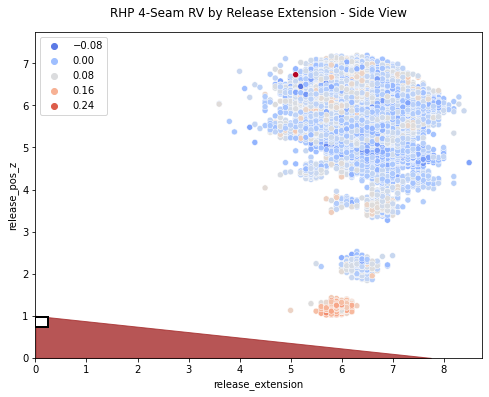

In [22]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_r, x = 'release_extension', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
#plt.legend(bbox_to_anchor = (1.15, .65))
plt.title('RHP 4-Seam RV by Release Extension - Side View', pad = 15);

## 4-Seam LHP

In [23]:
features_ff_l = ff_l.select_dtypes([np.number])
X = features_ff_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_ff_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_ff_l = sm.OLS(y_train, X_train).fit()
pred_ff_l = ols_ff_l.predict(X_test)
pred = ols_ff_l.predict(X_train)
fitted_vals_ff_l = ols_ff_l.fittedvalues
residuals_ff_l = ols_ff_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_l), 3))
print(ols_ff_l.summary())

RMSE: 0.301
MAE: 0.156
                            OLS Regression Results                            
Dep. Variable:                     rv   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     64.50
Date:                Wed, 23 Mar 2022   Prob (F-statistic):          1.41e-118
Time:                        19:40:52   Log-Likelihood:                -13506.
No. Observations:               54970   AIC:                         2.703e+04
Df Residuals:                   54960   BIC:                         2.712e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const          

In [24]:
X = features_ff_l.drop(columns = ['rv'])
y = features_ff_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LinearRegression()

lr.fit(X_train, y_train)
pred_ff_l = lr.predict(X_test)
pred = lr.predict(X)
score_ff_l = lr.score(X_test, y_test)

print('R2 Score:', round(score_ff_l, 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_l), 3))
print('Max Error:', round(metrics.max_error(y_test, pred_ff_l), 3))

R2 Score: 0.01
RMSE: 0.301
MAE: 0.156
Max Error: 2.112


### LHP 4-Seam Actual & Predicted Run Values

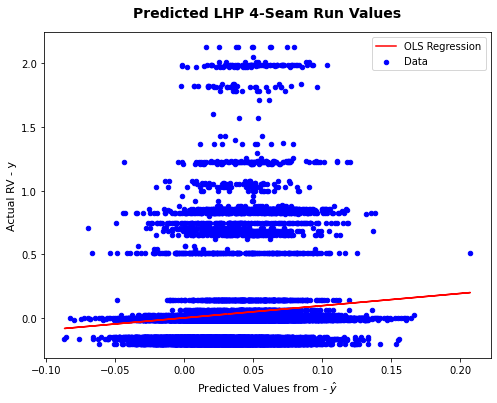

In [25]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_l, y_test, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_l, np.poly1d(np.polyfit(pred_ff_l, y_test, 1))(pred_ff_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP 4-Seam Probability Plot

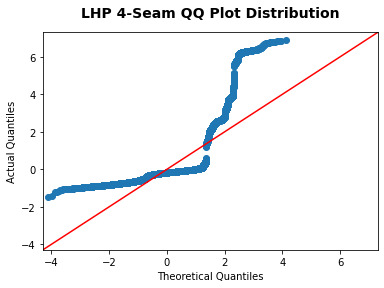

In [26]:
sm.qqplot(residuals_ff_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP 4-Seam RV Table

In [27]:
ff_l['n_pitches'] = [1 if x == 'FF' else 0 for x in ff_l['pitch_type']]
ff_l['xRV'] = pred
ff_l['xRV'] = round(ff_l['xRV'], 3)
grouped_ff_l = ff_l.groupby(['player_name', 'pitch_type'], as_index = False)['n_pitches', 'rv', 'xRV'].sum()

grouped_ff_l = pd.DataFrame(grouped_ff_l)
grouped_ff_l['RV/100'] = round(((grouped_ff_l['rv'] / grouped_ff_l['n_pitches']) * 100), 2)
grouped_ff_l['xRV/100'] = round(((grouped_ff_l['xRV'] / grouped_ff_l['n_pitches']) * 100), 2)

ff_l_group = pd.merge(ff_l, grouped_ff_l, how = 'left', on = ['player_name'])
ff_l_group.drop(columns = ['n_pitches_x', 'pitch_type_y'], inplace = True)

ff_l_group.rename(columns = col_dict, inplace = True)
ff_l_lv_table = ff_l_group.groupby(['player_name', 'pitch_type'], as_index = False)['n_pitches', 'RV', 
                                                                                    'RV/100', 'xRV', 
                                                                                    'xRV/100'].mean()
ff_l_lv_table = pd.DataFrame(ff_l_lv_table)
print(ff_l_lv_table.shape)
ff_l_lv_table.head()

(210, 7)


,player_name,pitch_type,n_pitches,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",FF,18.0,2.837,15.76,0.939,5.22
1,"Aguilar, Miguel",FF,62.0,1.650,2.66,2.463,3.97
2,"Akin, Keegan",FF,1009.0,12.219,1.21,35.245,3.49
3,"Albers, Andrew",FF,116.0,4.396,3.79,6.132,5.29
4,"Alexander, Tyler",FF,244.0,9.134,3.74,10.330,4.23


### LHP 4-Seam RV by Velo & Spin Rate

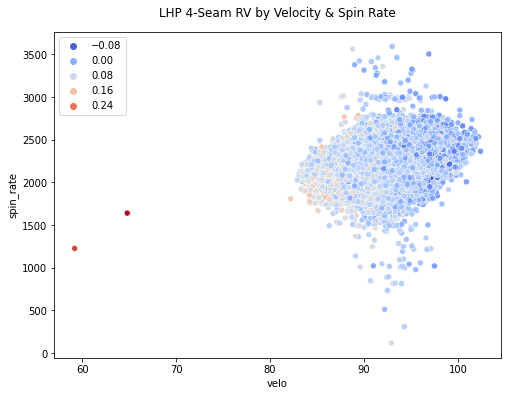

In [28]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_l_group, x = 'velo', y = 'spin_rate', hue = pred, palette = 'coolwarm')
plt.title('LHP 4-Seam RV by Velocity & Spin Rate', pad = 15);

### LHP 4-Seam RV by Strike Zone

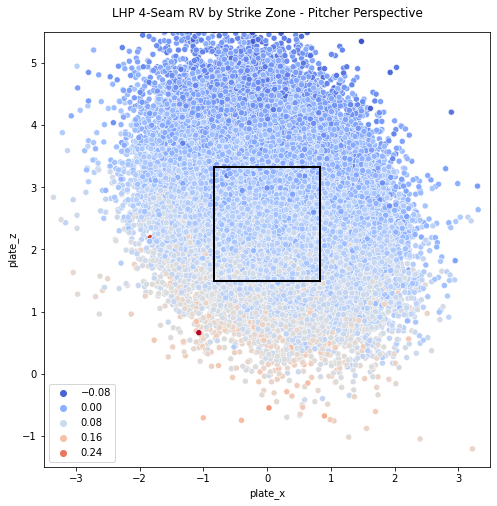

In [34]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_l, x = 'plate_x', y = 'plate_z', hue = pred, palette = 'coolwarm')
plt.xlim(-3.5, 3.5), plt.ylim(-1.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('LHP 4-Seam RV by Strike Zone - Pitcher Perspective', pad = 15);

### LHP 4-Seam RV by HB & VB

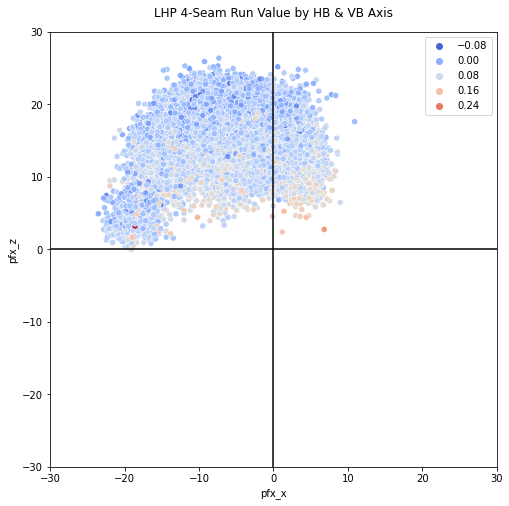

In [30]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_l, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP 4-Seam Run Value by HB & VB Axis', pad = 15);

### LHP 4-Seam RV by Release Point

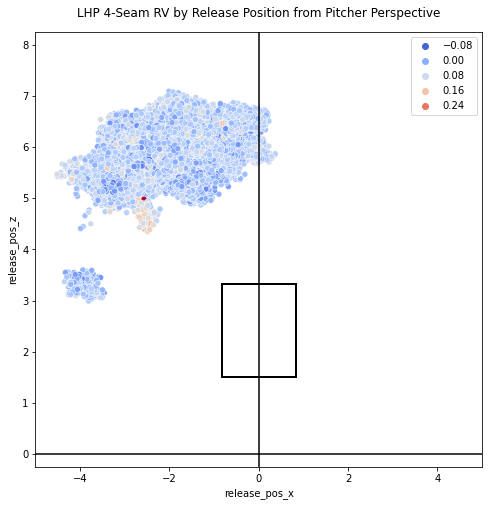

In [33]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_l, x = 'release_pos_x', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('LHP 4-Seam RV by Release Position from Pitcher Perspective', pad = 15);

### LHP 4-Seam RV by Release Extension

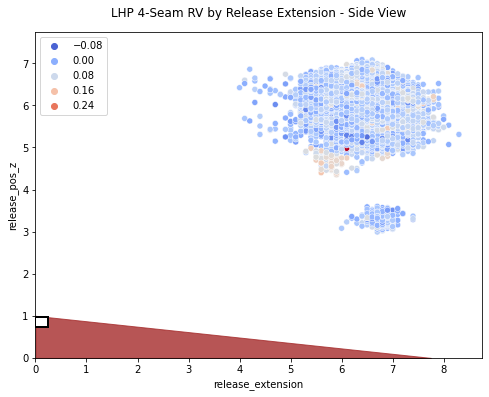

In [32]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_l, x = 'release_extension', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
#plt.legend(bbox_to_anchor = (1.15, .65))
plt.title('LHP 4-Seam RV by Release Extension - Side View', pad = 15);

## Cutter RHP

In [112]:
features_fc_r = fc_r.select_dtypes([np.number])
X = features_fc_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_fc_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_fc_r = sm.OLS(y_train, X_train).fit()
pred_fc_r = ols_fc_r.predict(X_test)
pred = ols_fc_r.predict(X_train)
fitted_vals_fc_r = ols_fc_r.fittedvalues
residuals_fc_r = ols_fc_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_r), 3))
print(ols_fc_r.summary())

MSE: 0.0332
RMSE: 0.1821
MAE: 0.0945
Train MSE: 0.0313
Train RMSE: 0.1769
Train MAE: 0.091
                            OLS Regression Results                            
Dep. Variable:                     rv   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.928
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           2.56e-08
Time:                        20:02:14   Log-Likelihood:                 7327.2
No. Observations:               23385   AIC:                        -1.463e+04
Df Residuals:                   23375   BIC:                        -1.455e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

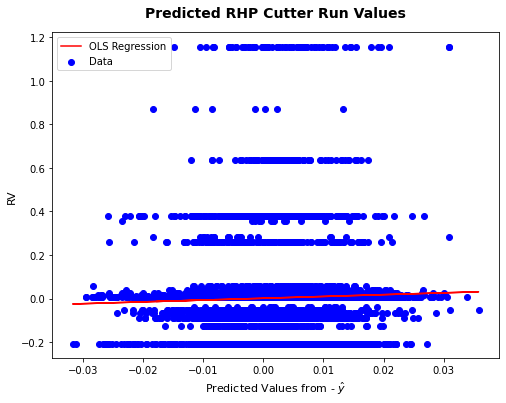

In [113]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_r, np.poly1d(np.polyfit(pred_fc_r, y_test, 1))(pred_fc_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

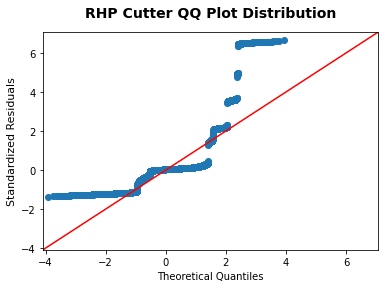

In [114]:
sm.qqplot(residuals_fc_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Cutter LHP

In [17]:
features_fc_l = fc_l.select_dtypes([np.number])
X = features_fc_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_fc_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_fc_l = sm.OLS(y_train, X_train).fit()
pred_fc_l = ols_fc_l.predict(X_test)
pred = ols_fc_l.predict(X_train)
fitted_vals_fc_l = ols_fc_l.fittedvalues
residuals_fc_l = ols_fc_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_l), 3))
print(ols_fc_l.summary())

MSE: 0.0033
RMSE: 0.0573
MAE: 0.0496
Train MSE: 0.0033
Train RMSE: 0.0572
Train MAE: 0.0496
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     11.97
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           5.30e-19
Time:                        14:38:23   Log-Likelihood:                 17591.
No. Observations:               12196   AIC:                        -3.516e+04
Df Residuals:                   12186   BIC:                        -3.509e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

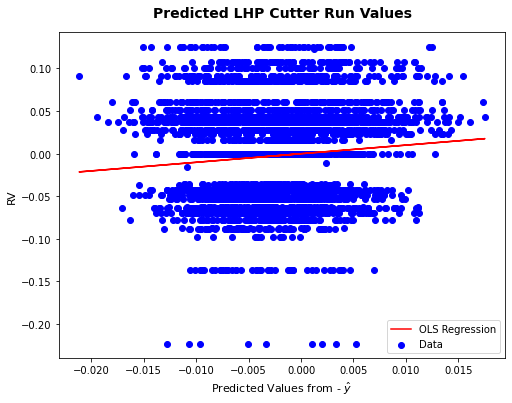

In [18]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_l, np.poly1d(np.polyfit(pred_fc_l, y_test, 1))(pred_fc_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

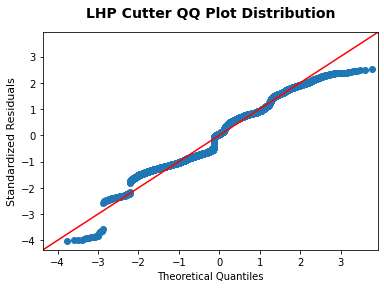

In [19]:
sm.qqplot(residuals_fc_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker RHP

In [20]:
features_si_r = si_r.select_dtypes([np.number])
X = features_si_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_si_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_si_r = sm.OLS(y_train, X_train).fit()
pred_si_r = ols_si_r.predict(X_test)
pred = ols_si_r.predict(X_train)
fitted_vals_si_r = ols_si_r.fittedvalues
residuals_si_r = ols_si_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_si_r), 3))

print(ols_si_r.summary())

MSE: 0.0036
RMSE: 0.06
MAE: 0.0516
Train MSE: 0.0036
Train RMSE: 0.0603
Train MAE: 0.0518
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     13.58
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           5.01e-22
Time:                        14:38:23   Log-Likelihood:                 78875.
No. Observations:               56750   AIC:                        -1.577e+05
Df Residuals:                   56740   BIC:                        -1.576e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

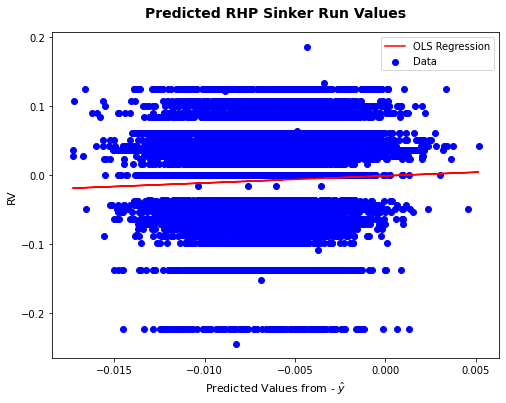

In [21]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_r, np.poly1d(np.polyfit(pred_si_r, y_test, 1))(pred_si_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

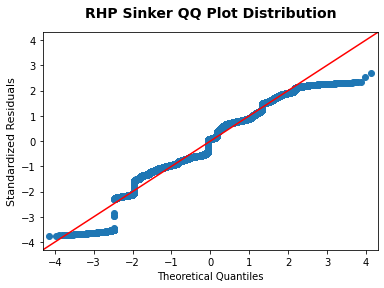

In [22]:
sm.qqplot(residuals_si_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker LHP

In [23]:
features_si_l = si_l.select_dtypes([np.number])
X = features_si_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_si_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_si_l = sm.OLS(y_train, X_train).fit()
pred_si_l = ols_si_l.predict(X_test)
pred = ols_si_l.predict(X_train)
fitted_vals_si_l = ols_si_l.fittedvalues
residuals_si_l = ols_si_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_si_l), 3))
print(ols_si_l.summary())

MSE: 0.0036
RMSE: 0.0603
MAE: 0.0518
Train MSE: 0.0036
Train RMSE: 0.06
Train MAE: 0.0515
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.570
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           6.29e-13
Time:                        14:38:23   Log-Likelihood:                 34986.
No. Observations:               25102   AIC:                        -6.995e+04
Df Residuals:                   25092   BIC:                        -6.987e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

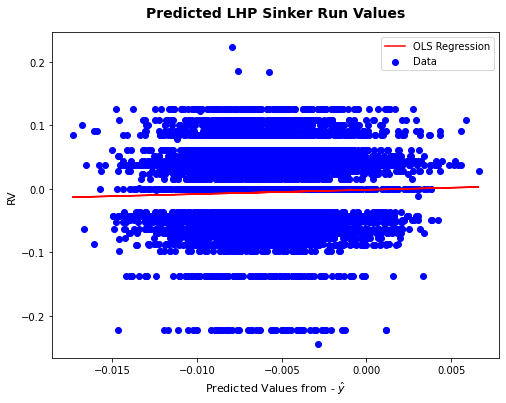

In [24]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_l, np.poly1d(np.polyfit(pred_si_l, y_test, 1))(pred_si_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

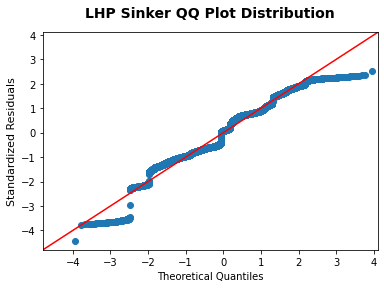

In [25]:
sm.qqplot(residuals_si_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider RHP

In [26]:
features_sl_r = sl_r.select_dtypes([np.number])
X = features_sl_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_sl_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_sl_r = sm.OLS(y_train, X_train).fit()
pred_sl_r = ols_sl_r.predict(X_test)
pred = ols_sl_r.predict(X_train)
fitted_vals_sl_r = ols_sl_r.fittedvalues
residuals_sl_r = ols_sl_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_r), 3))

print(ols_sl_r.summary())

MSE: 0.0031
RMSE: 0.0555
MAE: 0.0469
Train MSE: 0.0031
Train RMSE: 0.0555
Train MAE: 0.0471
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     392.7
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:24   Log-Likelihood:             1.1123e+05
No. Observations:               75569   AIC:                        -2.224e+05
Df Residuals:                   75559   BIC:                        -2.224e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

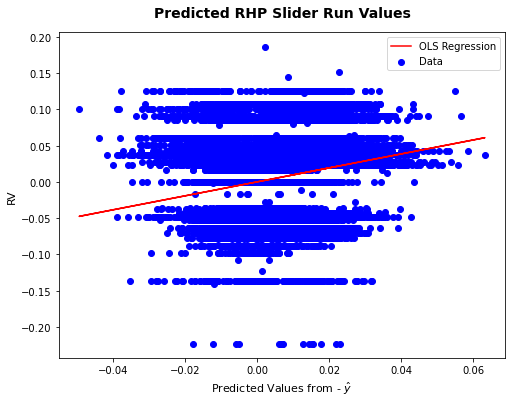

In [27]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_r, np.poly1d(np.polyfit(pred_sl_r, y_test, 1))(pred_sl_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

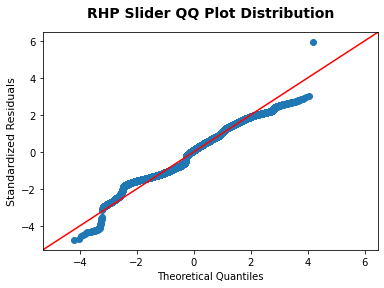

In [28]:
sm.qqplot(residuals_sl_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('RHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider LHP

In [29]:
features_sl_l = sl_l.select_dtypes([np.number])
X = features_sl_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_sl_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_sl_l = sm.OLS(y_train, X_train).fit()
pred_sl_l = ols_sl_l.predict(X_test)
pred = ols_sl_l.predict(X_train)
fitted_vals_sl_l = ols_sl_l.fittedvalues
residuals_sl_l = ols_sl_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_l), 3))

print(ols_sl_l.summary())

MSE: 0.0031
RMSE: 0.0554
MAE: 0.047
Train MSE: 0.0031
Train RMSE: 0.0556
Train MAE: 0.0471
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     125.8
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          7.29e-233
Time:                        14:38:24   Log-Likelihood:                 38342.
No. Observations:               26085   AIC:                        -7.666e+04
Df Residuals:                   26075   BIC:                        -7.658e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

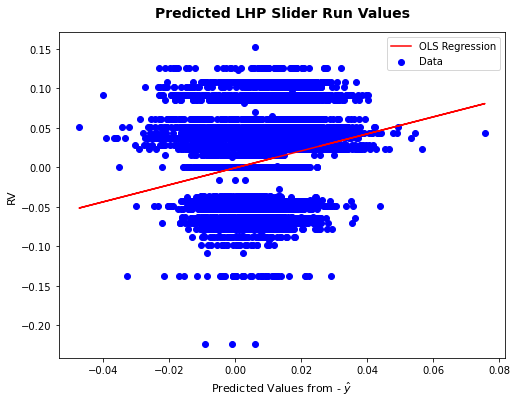

In [30]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_l, np.poly1d(np.polyfit(pred_sl_l, y_test, 1))(pred_sl_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

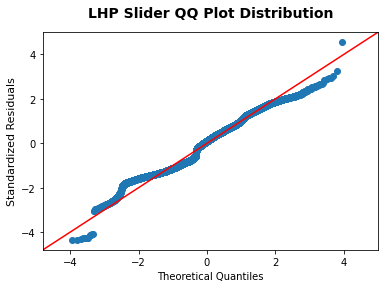

In [31]:
sm.qqplot(residuals_sl_l, line = '45', fit = True)

plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball RHP

In [32]:
features_cu_r = cu_r.select_dtypes([np.number])
X = features_cu_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_cu_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_cu_r = sm.OLS(y_train, X_train).fit()
pred_cu_r = ols_cu_r.predict(X_test)
pred = ols_cu_r.predict(X_train)
fitted_vals_cu_r = ols_cu_r.fittedvalues
residuals_cu_r = ols_cu_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_r), 3))

print(ols_cu_r.summary())

MSE: 0.0028
RMSE: 0.0525
MAE: 0.0448
Train MSE: 0.0028
Train RMSE: 0.0529
Train MAE: 0.045
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     119.2
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          3.91e-221
Time:                        14:38:25   Log-Likelihood:                 45618.
No. Observations:               29991   AIC:                        -9.122e+04
Df Residuals:                   29981   BIC:                        -9.113e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

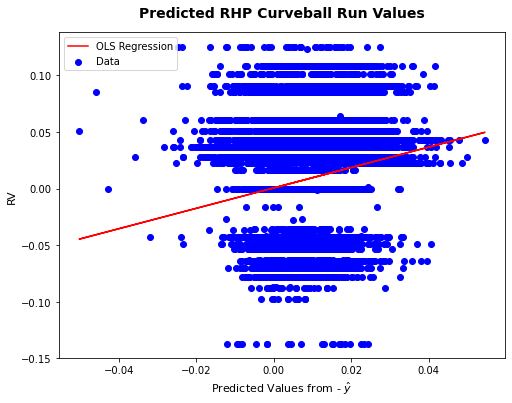

In [33]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_r, np.poly1d(np.polyfit(pred_cu_r, y_test, 1))(pred_cu_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

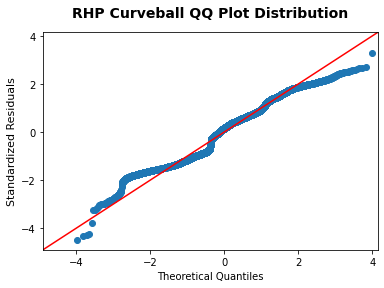

In [34]:
sm.qqplot(residuals_cu_r, line='45', fit=True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('RHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball LHP

In [35]:
features_cu_l = cu_l.select_dtypes([np.number])
X = features_cu_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_cu_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_cu_l = sm.OLS(y_train, X_train).fit()
pred_cu_l = ols_cu_l.predict(X_test)
pred = ols_cu_l.predict(X_train)
fitted_vals_cu_l = ols_cu_l.fittedvalues
residuals_cu_l = ols_cu_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_l), 3))

print(ols_cu_l.summary())

MSE: 0.0028
RMSE: 0.0527
MAE: 0.0447
Train MSE: 0.0028
Train RMSE: 0.0531
Train MAE: 0.0451
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     48.00
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           4.73e-86
Time:                        14:38:25   Log-Likelihood:                 21360.
No. Observations:               14084   AIC:                        -4.270e+04
Df Residuals:                   14074   BIC:                        -4.262e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

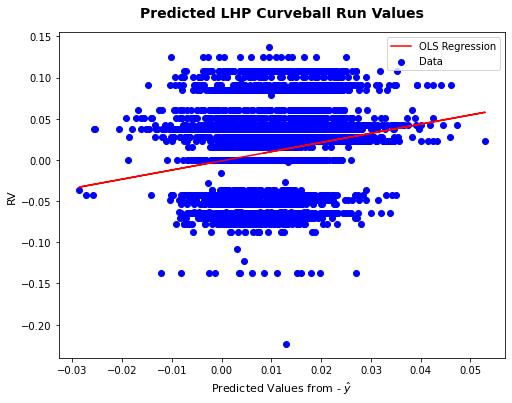

In [36]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_l, np.poly1d(np.polyfit(pred_cu_l, y_test, 1))(pred_cu_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

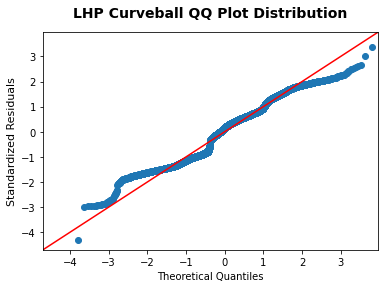

In [37]:
sm.qqplot(residuals_cu_l, line='45', fit=True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup RHP

In [38]:
features_ch_r = ch_r.select_dtypes([np.number])
X = features_ch_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_ch_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_ch_r = sm.OLS(y_train, X_train).fit()
pred_ch_r = ols_ch_r.predict(X_test)
pred = ols_ch_r.predict(X_train)
fitted_vals_ch_r = ols_ch_r.fittedvalues
residuals_ch_r = ols_ch_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_r), 3))

print(ols_ch_r.summary())

MSE: 0.0032
RMSE: 0.0562
MAE: 0.0475
Train MSE: 0.0032
Train RMSE: 0.0565
Train MAE: 0.0479
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     187.9
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:25   Log-Likelihood:                 55228.
No. Observations:               37989   AIC:                        -1.104e+05
Df Residuals:                   37979   BIC:                        -1.104e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

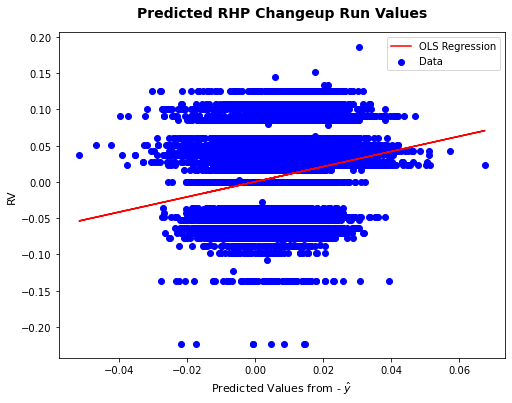

In [39]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_r, np.poly1d(np.polyfit(pred_ch_r, y_test, 1))(pred_ch_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

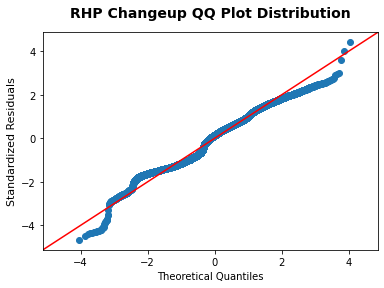

In [40]:
sm.qqplot(residuals_ch_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup LHP

In [41]:
features_ch_l = ch_l.select_dtypes([np.number])
X = features_ch_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_ch_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_ch_l = sm.OLS(y_train, X_train).fit()
pred_ch_l = ols_ch_l.predict(X_test)
pred = ols_ch_l.predict(X_train)
fitted_vals_ch_l = ols_ch_l.fittedvalues
residuals_ch_l = ols_ch_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_l), 3))

print(ols_ch_l.summary())

MSE: 0.0031
RMSE: 0.0557
MAE: 0.0465
Train MSE: 0.0031
Train RMSE: 0.0555
Train MAE: 0.0466
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     159.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          9.78e-294
Time:                        14:38:26   Log-Likelihood:                 32778.
No. Observations:               22251   AIC:                        -6.554e+04
Df Residuals:                   22241   BIC:                        -6.546e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

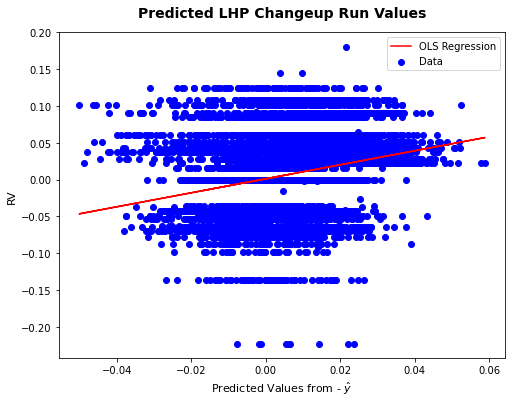

In [42]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_l, np.poly1d(np.polyfit(pred_ch_l, y_test, 1))(pred_ch_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

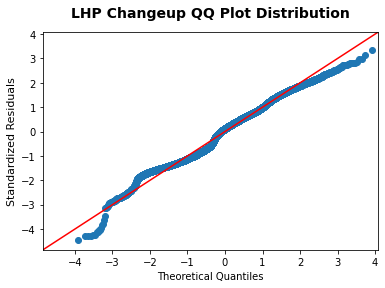

In [43]:
sm.qqplot(residuals_ch_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

# Grouped Pitches

## Fastball RHP

#### 4-Seam, Cutter, Sinker

In [44]:
features_fastball_r = rhp_fastball.select_dtypes([np.number])
X = features_fastball_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_fastball_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_fastball_r = sm.OLS(y_train, X_train).fit()
pred_fastball_r = ols_fastball_r.predict(X_test)
fitted_vals_fastball_r = ols_fastball_r.fittedvalues
residuals_fastball_r = ols_fastball_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_r), 3))
print(ols_fastball_r.summary())

MSE: 0.0036
RMSE: 0.06
MAE: 0.0512
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     194.6
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:26   Log-Likelihood:             2.9544e+05
No. Observations:              212418   AIC:                        -5.909e+05
Df Residuals:                  212408   BIC:                        -5.908e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
con

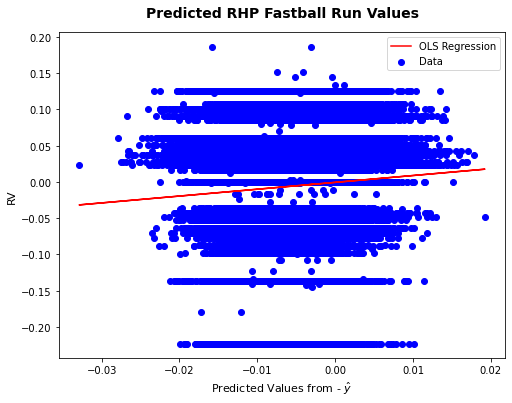

In [45]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_fastball_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fastball_r, np.poly1d(np.polyfit(pred_fastball_r, y_test, 1))(pred_fastball_r), c = 'r',
         label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

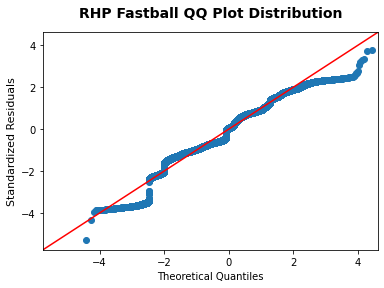

In [46]:
sm.qqplot(residuals_fastball_r, line = '45', fit = True)

plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Fastball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Fastball LHP

#### 4-Seam, Cutter, Sinker

In [47]:
features_fastball_l = lhp_fastball.select_dtypes([np.number])
X = features_fastball_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_fastball_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_fastball_l = sm.OLS(y_train, X_train).fit()
pred_fastball_l = ols_fastball_l.predict(X_test)
fitted_vals_fastball_l = ols_fastball_l.fittedvalues
residuals_fastball_l = ols_fastball_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_l), 3))
print(ols_fastball_l.summary())

MSE: 0.0036
RMSE: 0.0601
MAE: 0.0512
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     68.98
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          1.97e-127
Time:                        14:38:27   Log-Likelihood:             1.2839e+05
No. Observations:               92276   AIC:                        -2.568e+05
Df Residuals:                   92266   BIC:                        -2.567e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

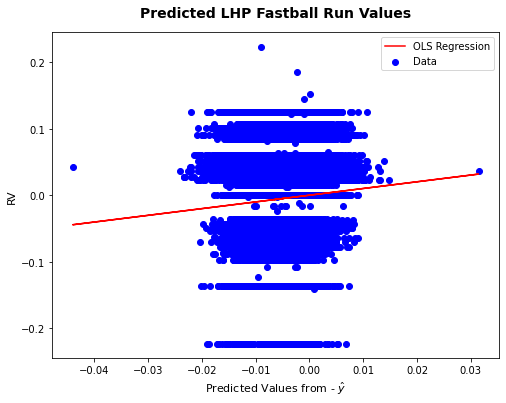

In [48]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_fastball_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fastball_l, np.poly1d(np.polyfit(pred_fastball_l, y_test, 1))(pred_fastball_l), c = 'r', 
         label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

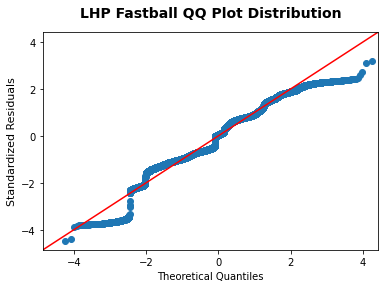

In [49]:
sm.qqplot(residuals_fastball_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP Fastball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [50]:
features_bb_r = rhp_breaking_ball.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_bb_r = sm.OLS(y_train, X_train).fit()
pred_bb_r = ols_bb_r.predict(X_test)
fitted_vals_bb_r = ols_bb_r.fittedvalues
residuals_bb_r = ols_bb_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3))
print(ols_bb_r.summary())

MSE: 0.003
RMSE: 0.0548
MAE: 0.0465
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     494.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:28   Log-Likelihood:             1.6977e+05
No. Observations:              114287   AIC:                        -3.395e+05
Df Residuals:                  114277   BIC:                        -3.394e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

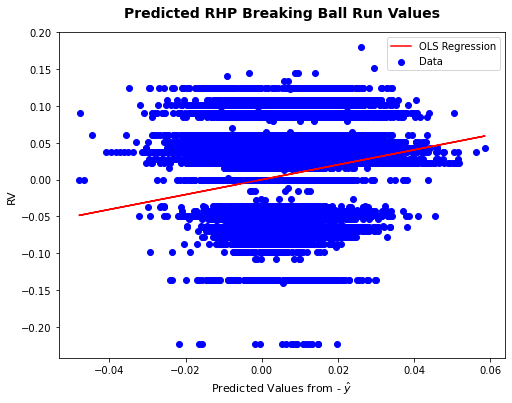

In [51]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_bb_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_bb_r, np.poly1d(np.polyfit(pred_bb_r, y_test, 1))(pred_bb_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

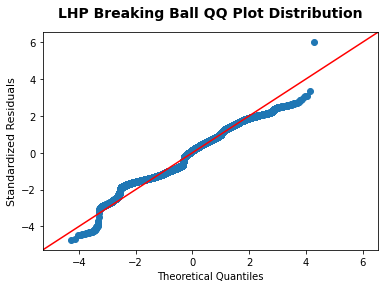

In [52]:
sm.qqplot(residuals_bb_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Breaking Ball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball LHP

#### Slider, Curveball, Knuckle Curve

In [53]:
features_bb_l = lhp_breaking_ball.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_bb_l = sm.OLS(y_train, X_train).fit()
pred_bb_l = ols_bb_l.predict(X_test)
fitted_vals_bb_l = ols_bb_l.fittedvalues
residuals_bb_l = ols_bb_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3))
print(ols_bb_l.summary())

MSE: 0.003
RMSE: 0.0545
MAE: 0.0464
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     175.6
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:28   Log-Likelihood:                 61949.
No. Observations:               41699   AIC:                        -1.239e+05
Df Residuals:                   41689   BIC:                        -1.238e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

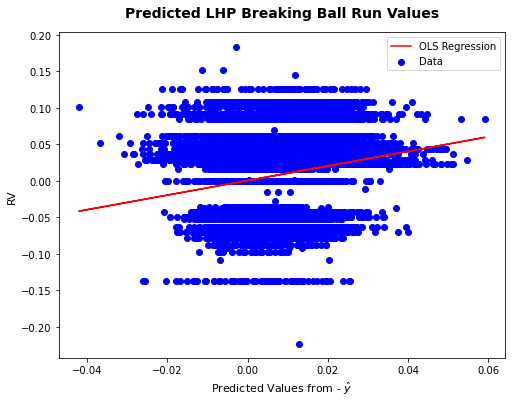

In [54]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_bb_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_bb_l, np.poly1d(np.polyfit(pred_bb_l, y_test, 1))(pred_bb_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

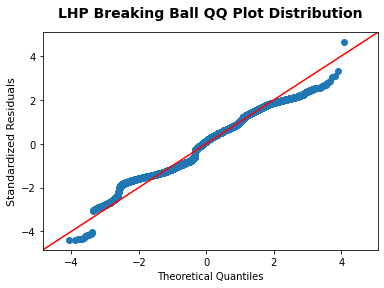

In [55]:
sm.qqplot(residuals_bb_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP Breaking Ball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-speed RHP

#### Changeup, Splitter

In [56]:
features_os_r = rhp_offspeed.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_os_r = sm.OLS(y_train, X_train).fit()
pred_os_r = ols_os_r.predict(X_test)
fitted_vals_os_r = ols_os_r.fittedvalues
residuals_os_r = ols_os_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3))
print(ols_os_r.summary())

MSE: 0.0032
RMSE: 0.0563
MAE: 0.0477
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     218.5
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:29   Log-Likelihood:                 66491.
No. Observations:               45668   AIC:                        -1.330e+05
Df Residuals:                   45658   BIC:                        -1.329e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

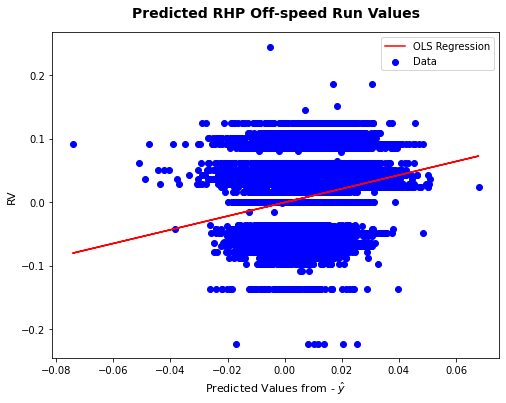

In [57]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_os_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_os_r, np.poly1d(np.polyfit(pred_os_r, y_test, 1))(pred_os_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Off-speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

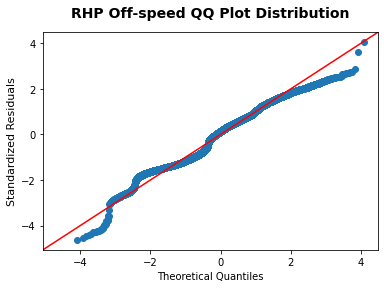

In [58]:
sm.qqplot(residuals_os_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Off-speed QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-speed LHP

#### Changeup, Splitter

In [59]:
features_os_l = lhp_offspeed.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_os_l = sm.OLS(y_train, X_train).fit()
pred_os_l = ols_os_l.predict(X_test)
fitted_vals_os_l = ols_os_l.fittedvalues
residuals_os_l = ols_os_l.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3))
print(ols_os_l.summary())

MSE: 0.0031
RMSE: 0.0557
MAE: 0.0466
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     160.9
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          9.29e-297
Time:                        14:38:29   Log-Likelihood:                 33415.
No. Observations:               22703   AIC:                        -6.681e+04
Df Residuals:                   22693   BIC:                        -6.673e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

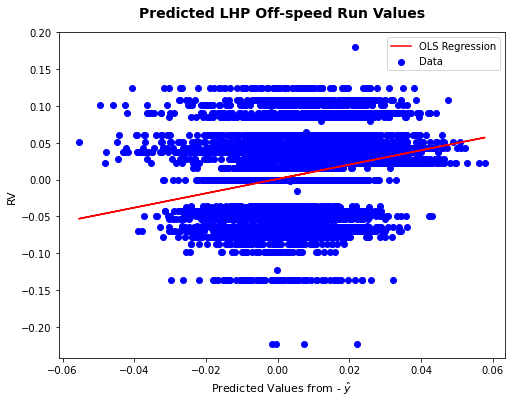

In [60]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_os_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_os_l, np.poly1d(np.polyfit(pred_os_l, y_test, 1))(pred_os_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Off-speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

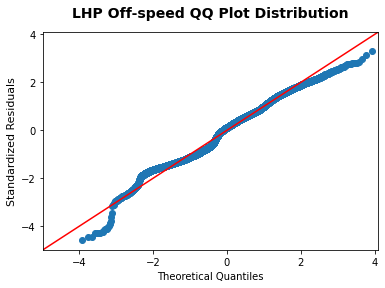

In [61]:
sm.qqplot(residuals_os_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Off-speed QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);